## Detalle sobre este notebook (fv_periodo):
* Este notebook utiliza los programas presidenciales del cualquier período de 5 años, los compara según su correlación por temas etiquetados, por país.
* Selecciona un Feature Vector acotado
* Construye una red de similaridad.
* Luego identifica comunidades.
* Luego estima métricas de centralidad
* al final tiene conclusiones sobre el período #15 (1990-1994)

#### Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from networkx.algorithms import community
import community as community_louvain


#### Cargar df_5_extended

In [2]:
df_5_extended = pd.read_excel('df_5_extended.xlsx')
df_5_extended.head()

countryname  ventana_5    per101   per102    per103    per104    per105  \
0     Albania         15  3.113815  0.00000  1.559835  2.046771  0.331285   
1     Albania         16  3.716797  0.00000  0.051879  3.519091  0.015910   
2     Albania         17  2.392570  0.00000  0.000000  2.757403  0.026619   
3   Argentina         14  0.000000  0.00000  4.619213  0.448618  0.828036   
4   Argentina         16  0.254185  0.02014  0.725611  1.406834  0.100835   

     per106    per107    per108  ...  per606_1  per606_2  per607_1  per607_2  \
0  1.674371  4.632186  5.169904  ...  0.000000       0.0  0.000000       0.0   
1  0.579077  4.971347  1.981720  ...  0.000000       0.0  0.000000       0.0   
2  0.023948  3.523162  1.452779  ...  0.000000       0.0  0.000000       0.0   
3  0.338070  2.955090  0.000000  ...  7.595332       0.0  0.326532       0.0   
4  1.720736  5.478894  3.932102  ...  4.494125       0.0  0.443809       0.0   

   per607_3  per608_1  per608_2  per608_3  per703_1  per703_2  
0  0.000000       0.0       0.0       0.0  0.000000       0.0  
1  0.000000       0.0       0.0       0.0  0.000000       0.0  
2  0.000000       0.0       0.0       0.0  0.000000       0.0  
3  0.000000       0.0       0.0       0.0  2.495280       0.0  
4  0.809128       0.0       0.0       0.0  2.573783       0.0  

[5 rows x 144 columns]

In [3]:
df_5_extended.shape

(1407, 144)

In [4]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()


Dominio      Nombre_Dominio Variable_per  \
0  Domain_1  External Relations       per101   
1  Domain_1  External Relations       per102   
2  Domain_1  External Relations       per103   
3  Domain_1  External Relations       per104   
4  Domain_1  External Relations       per105   

                           Detalle_Dominio  
0  Foreign Special Relationships: Positive  
1  Foreign Special Relationships: Negative  
2                         Anti-Imperialism  
3                       Military: Positive  
4                       Military: Negative

In [5]:
all_per_variables = [col for col in df_5_extended.columns if col.startswith('per')]
all_per_variables

['per101',
 'per102',
 'per103',
 'per104',
 'per105',
 'per106',
 'per107',
 'per108',
 'per109',
 'per110',
 'per201',
 'per202',
 'per203',
 'per204',
 'per301',
 'per302',
 'per303',
 'per304',
 'per305',
 'per401',
 'per402',
 'per403',
 'per404',
 'per405',
 'per406',
 'per407',
 'per408',
 'per409',
 'per410',
 'per411',
 'per412',
 'per413',
 'per414',
 'per415',
 'per416',
 'per501',
 'per502',
 'per503',
 'per504',
 'per505',
 'per506',
 'per507',
 'per601',
 'per602',
 'per603',
 'per604',
 'per605',
 'per606',
 'per607',
 'per608',
 'per701',
 'per702',
 'per703',
 'per704',
 'per705',
 'per706',
 'per1011',
 'per1012',
 'per1013',
 'per1014',
 'per1015',
 'per1016',
 'per1021',
 'per1022',
 'per1023',
 'per1024',
 'per1025',
 'per1026',
 'per1031',
 'per1032',
 'per1033',
 'per2021',
 'per2022',
 'per2023',
 'per2031',
 'per2032',
 'per2033',
 'per2041',
 'per3011',
 'per3051',
 'per3052',
 'per3053',
 'per3054',
 'per3055',
 'per4011',
 'per4012',
 'per4013',
 'per4014',


In [6]:
len(all_per_variables)

142

#### 1. TRABAJO CON ASPECTOS PARTICULARES
   * Crearemos una lista de nombres de 'aspectos' junto con una lista de nombres de variables que lo explican
   * Consolidaremos 'df_5_extended' para que incluya solamente las volumnas de interés para cada aspecto.


#### 1.1 Lista de aspectos y variables de interés
* Aspecto específicos:
       
*          * Inclusión y Minorías
*          * Orden y Corrupción
*          * Medio Ambiente y Sostenibilidad
*          * Pueblos Originarios
*          * Derechos Humanos
*          * Inmigración
*          * Moral Tradicional 


#### Correlación de Pearson

**Qué es**: La correlación de Pearson mide la relación lineal entre dos conjuntos de datos. En este caso, mediría cómo se correlacionan los porcentajes de las etiquetas temáticas entre dos programas de gobierno.

**Aplicación**: Para cada par de programas de gobierno (por ejemplo, "Chile_1990" y "Alemania_1980"), calcula la correlación de Pearson usando sus respectivos vectores de porcentajes de las 56 etiquetas temáticas.

Si el vector de "Chile_1990" es `[x1,x2,...,x56]` y el de "Alemania_1980" es `[y1,y2,...,y56]`, entonces la correlación de Pearson se calcula como:

$$
r = \frac{\sum_{i=1}^{56} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{56} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{56} (y_i - \bar{y})^2}}
$$

Donde $\bar{x}$ y $\bar{y}$ son las medias de los vectores de porcentajes.

#### Interpretación de la Correlación:
El valor de $r$ está en el rango $[-1,1]$, donde:

- $r = 1$ indica una correlación positiva perfecta (discursos muy similares en la distribución temática).
- $r = -1$ indica una correlación negativa perfecta (discursos temáticamente opuestos).
- $r \approx 0$ indica que no hay una correlación lineal significativa.

#### Uso en la Red de Similaridad:
Usaremos el valor absoluto de la correlación ($|r|$) para ponderar la arista entre dos programas. Valores cercanos a 1 indican una fuerte similaridad temática, mientras que valores cercanos a 0 indican poca o ninguna similaridad.

---


#### Distancia Euclidiana

**Qué es**: La distancia euclidiana es una medida de disimilitud que calcula la distancia entre dos puntos en un espacio n-dimensional. En este caso, mide la distancia entre los vectores de porcentajes de etiquetas temáticas de dos programas de gobierno. A diferencia de la correlación, la distancia euclidiana se centra en la magnitud de las diferencias entre los temas, sin considerar relaciones lineales.

**Aplicación**: Para cada par de programas de gobierno (por ejemplo, "Chile_1990" y "Alemania_1980"), se calcula la distancia euclidiana usando sus respectivos vectores de porcentajes de las 56 etiquetas temáticas.

Si el vector de "Chile_1990" es \([x_1, x_2, ..., x_{56}]\) y el de "Alemania_1980" es \([y_1, y_2, ..., y_{56}]\), entonces la distancia euclidiana se calcula como:

$$
d = \sqrt{\sum_{i=1}^{56} (x_i - y_i)^2}
$$

#### Interpretación de la Distancia Euclidiana:
El valor de \(d\) está en el rango \([0, +\infty)\), donde:

- \(d = 0\) indica una similaridad perfecta, es decir, los programas tienen exactamente la misma distribución temática.
- Un valor mayor de \(d\) indica una mayor disimilitud entre los programas, es decir, sus distribuciones temáticas difieren más.

#### Uso en la Red de Similaridad:
Para obtener una medida de similaridad a partir de la distancia, podemos transformarla como:

$$
\text{similaridad} = \frac{1}{1 + d}
$$

Esto convierte la distancia en una escala inversa de similaridad, donde valores más cercanos a 1 indican alta similaridad temática y valores más cercanos a 0 indican baja similaridad.

---


#### Aspectos

In [7]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['Inclusion_y_Minorias', 'Orden_y_Corrupcion', 'Medio_Ambiente_y_Sostenibilidad', 'Pueblos_Originarios'],
    'var_1': ['per503', 'per605_1', 'per501', 'per607_3'],
    'var_2': ['per705', 'per605_2', 'per416_2', 'per608_3'],
    'var_3': ['per201_2', 'per304', None, None],  # None indica que no hay una tercera variable para el aspecto
    'var_4': [None, None, None, None]  # Ningún aspecto tiene cuarta variable
}

df_aspectos = pd.DataFrame(data_aspectos)

# Mostrar el DataFrame 'df_aspectos' para verificar su contenido
display(df_aspectos)

aspecto     var_1     var_2     var_3 var_4
0             Inclusion_y_Minorias    per503    per705  per201_2  None
1               Orden_y_Corrupcion  per605_1  per605_2    per304  None
2  Medio_Ambiente_y_Sostenibilidad    per501  per416_2      None  None
3              Pueblos_Originarios  per607_3  per608_3      None  None

#### Calculamos la similaridad tanto con correlación como con distancia euclideana

In [20]:
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import euclidean
import warnings

def calcular_similitud(df, df_aspectos, porcentaje, periodo):
    """Calcula la similaridad entre Chile y otros países para un período específico, utilizando correlación de Spearman y distancia euclideana."""
    similarity_results_spearman = defaultdict(list)
    similarity_results_euclidean = defaultdict(list)
    constantes = []  # Almacena países_período con valores constantes
    
    # Filtrar el dataframe para el período específico
    df = df[df['ventana_5'] == periodo]
    
    for _, row_aspecto in df_aspectos.iterrows():
        aspecto = row_aspecto['aspecto']
        variables = row_aspecto[['var_1', 'var_2', 'var_3', 'var_4']].dropna().tolist()
        
        columnas_relevantes = ['countryname', 'ventana_5'] + variables
        df_chile = df[df['countryname'] == 'Chile'][columnas_relevantes].copy()
        df_otros = df[df['countryname'] != 'Chile'][columnas_relevantes].copy()
        
        for _, row in df_otros.iterrows():
            country_period = row['countryname'] + '_' + str(row['ventana_5'])
            country_data = row[variables].dropna().astype(float)
            chile_periods = df_chile[df_chile['ventana_5'] >= row['ventana_5']]
            
            for _, chile_row in chile_periods.iterrows():
                chile_period = 'Chile_' + str(chile_row['ventana_5'])
                chile_data = chile_row[variables].dropna().astype(float)
                
                if len(country_data) == len(chile_data):
                    with warnings.catch_warnings(record=True) as w:
                        warnings.simplefilter("always")
                        spearman_corr = country_data.corr(chile_data, method='spearman')
                        spearman_corr = 0 if pd.isna(spearman_corr) else spearman_corr

                        # Verificar si alguna advertencia contiene 'An input array is constant'
                        for warn in w:
                            if "An input array is constant" in str(warn.message):
                                constantes.append(country_period)
                                spearman_corr = 0  # Asignamos 0 en caso de valores constantes

                    euclidean_dist = euclidean(country_data, chile_data)
                    print(f"country_period: {country_period}")
                    print(f"Country_data: {country_data}")
                    print(f"Chile_data: {chile_data}")
                    print(f"Dist Euclideana {euclidean_dist}")
                    euclidean_similarity = 1 / (1 + euclidean_dist)
                    print(f"similaridad = " + str(euclidean_similarity))
                else:
                    spearman_corr = 0
                    euclidean_similarity = 0

                similarity_results_spearman[(aspecto, country_period, chile_period)].append(spearman_corr)
                similarity_results_euclidean[(aspecto, country_period, chile_period)].append(euclidean_similarity)

    # Mostramos los casos con valores constantes
    if constantes:
        print("Países_Período con valores constantes en los datos:")
        print(set(constantes))

    final_results_spearman = {key: np.mean(values) for key, values in similarity_results_spearman.items()}
    final_results_euclidean = {key: np.mean(values) for key, values in similarity_results_euclidean.items()}

    # Crear dataframes con las columnas necesarias
    df_similarity_spearman = pd.DataFrame(
        list(final_results_spearman.items()), 
        columns=['Aspecto_Country_Period_And_Chile_Period', 'Spearman_Similarity']
    )
    df_similarity_euclidean = pd.DataFrame(
        list(final_results_euclidean.items()), 
        columns=['Aspecto_Country_Period_And_Chile_Period', 'Euclidean_Similarity']
    )
    
    # Separar las columnas 'Country_Period' y 'Chile_Period'
    df_similarity_spearman[['Aspecto', 'Country_Period', 'Chile_Period']] = pd.DataFrame(
        df_similarity_spearman['Aspecto_Country_Period_And_Chile_Period'].tolist(), index=df_similarity_spearman.index
    )
    df_similarity_euclidean[['Aspecto', 'Country_Period', 'Chile_Period']] = pd.DataFrame(
        df_similarity_euclidean['Aspecto_Country_Period_And_Chile_Period'].tolist(), index=df_similarity_euclidean.index
    )

    df_similarity_spearman.drop('Aspecto_Country_Period_And_Chile_Period', axis=1, inplace=True)
    df_similarity_euclidean.drop('Aspecto_Country_Period_And_Chile_Period', axis=1, inplace=True)
    
    print("CHECK DUPLICADOS ANTES DE LA AGREGACIÓN")
    print(df_similarity_euclidean[(df_similarity_euclidean['Country_Period'] == 'Brazil_15') & (df_similarity_euclidean['Chile_Period'] == 'Chile_15')])
    print("FIN CHECK DUPLICADOS")
    
    return df_similarity_spearman, df_similarity_euclidean


#### Generamos las Redes, Comunidades y Métricas de Centralidad

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import pandas as pd

def generar_red_y_calcular_metricas(df_similarity, aspecto, tipo_similitud, porcentaje):
    # Filtramos los x% enlaces con mayor similaridad
    df_similarity = df_similarity.sort_values(by=tipo_similitud, ascending=False)
    top_x_percent = int(len(df_similarity) * (porcentaje / 100))
    df_top_similarity = df_similarity.head(top_x_percent)

    # Agrupamos duplicados promediando los valores de similaridad para cada par único
    df_top_similarity = df_top_similarity.groupby(['Country_Period', 'Chile_Period'], as_index=False).agg({tipo_similitud: 'mean'})
    
    # Redondeamos la similaridad a 4 decimales
    df_top_similarity[tipo_similitud] = df_top_similarity[tipo_similitud].round(4)
    
    # Generamos el heatmap de similaridad
    try:
        heatmap_data = df_top_similarity.pivot(index='Country_Period', columns='Chile_Period', values=tipo_similitud)

        # Ordenar las filas y columnas en base a la similaridad o correlación promedio
        heatmap_data = heatmap_data.loc[heatmap_data.mean(axis=1).sort_values(ascending=False).index]
        heatmap_data = heatmap_data[heatmap_data.mean().sort_values(ascending=False).index]

        # Preparar datos para la tabla (nodos y similaridades ordenados de mayor a menor)
        sorted_similarities = df_top_similarity[['Country_Period', tipo_similitud]].sort_values(by=tipo_similitud, ascending=False)
        
        # Crear una figura con dos subplots: uno para el heatmap y otro para la tabla
        fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(15, 8))
        
        # Plotear el heatmap en el primer subplot
        sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="coolwarm", linewidths=0.5, linecolor='gray', 
                    cbar_kws={'label': f'Similitud ({tipo_similitud})'}, vmin=0, vmax=1, ax=ax[0])
        ax[0].set_title(f'Heatmap - {aspecto} ({porcentaje}% enlaces más fuertes) - {tipo_similitud}')
        
        # Plotear la tabla en el segundo subplot
        ax[1].axis('off')  # Desactivar los ejes de la tabla
        table_data = sorted_similarities.head(40)  # Mostrar los 40 primeros valores
        table = ax[1].table(cellText=table_data.values, colLabels=["Country_Period", tipo_similitud], cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)  # Reducir el tamaño de fuente
        table.scale(1.0, 1.0)  # Ajustar la escala de la tabla

        plt.show()
    except ValueError as e:
        print(f"Error al crear el heatmap: {e}. Verifique que no haya demasiados valores duplicados.")

    # [El resto del código permanece igual...]

    # Construcción de la red con pesos en los enlaces
    G = nx.Graph()
    for _, row in df_top_similarity.iterrows():
        nodo_chile = row['Chile_Period']
        nodo_pais = row['Country_Period']
        G.add_edge(nodo_chile, nodo_pais, weight=row[tipo_similitud])

    # Configuración de colores de los enlaces según la fuerza del enlace
    weights = nx.get_edge_attributes(G, 'weight').values()
    norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
    colors = [cm.coolwarm(norm(weight)) for weight in weights]

    # Visualización de la red de similaridad con enlaces de color gradiente
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Red de Similitud - {aspecto} ({porcentaje}% enlaces más fuertes) - {tipo_similitud}')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Fuerza del Enlace')
    plt.show()
    
    # Clustering y cálculo de métricas de centralidad
    partition = community.louvain_communities(G, weight='weight')
    num_clusters = len(partition)
    print(f"Se identificaron {num_clusters} clusters para el aspecto '{aspecto}'.")

    # Visualización del gráfico de comunidades
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    colors = cm.rainbow(np.linspace(0, 1, num_clusters))  # Colores para cada comunidad
    for i, comm in enumerate(partition):
        nx.draw_networkx_nodes(G, pos, nodelist=list(comm), node_size=300, node_color=[colors[i]], label=f'Comunidad {i}')
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Comunidades detectadas - {aspecto} - {tipo_similitud}')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Fuerza del Enlace')
    plt.legend(loc="best")
    plt.show()

    # Cálculo de métricas de centralidad
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    df_centralities = pd.DataFrame({
        'Nodo': list(degree.keys()),
        'Degree_Centrality': list(degree.values()),
        'Betweenness_Centrality': list(betweenness.values()),
        'Eigenvector_Centrality': list(eigenvector.values()),
        'Aspecto': aspecto
    })
    
    return df_centralities


#### Ejecución


Analizando: Inclusion_y_Minorias en el período 15
country_period: Albania_15
Country_data: per503      3.802823
per705      0.165306
per201_2    0.000000
Name: 0, dtype: float64
Chile_data: per503      7.311582
per705      0.274453
per201_2    1.145095
Name: 102, dtype: float64
Dist Euclideana 3.6924989137672073
similaridad = 0.21310606957545042
country_period: Australia_15
Country_data: per503      4.361432
per705      1.818412
per201_2    0.000000
Name: 24, dtype: float64
Chile_data: per503      7.311582
per705      0.274453
per201_2    1.145095
Name: 102, dtype: float64
Dist Euclideana 3.521140950086901
similaridad = 0.2211831064414789
country_period: Austria_15
Country_data: per503      8.771010
per705      4.012913
per201_2    0.000000
Name: 40, dtype: float64
Chile_data: per503      7.311582
per705      0.274453
per201_2    1.145095
Name: 102, dtype: float64
Dist Euclideana 4.173398248991458
similaridad = 0.19329654356204795
country_period: Belgium_15
Country_data: per503      2

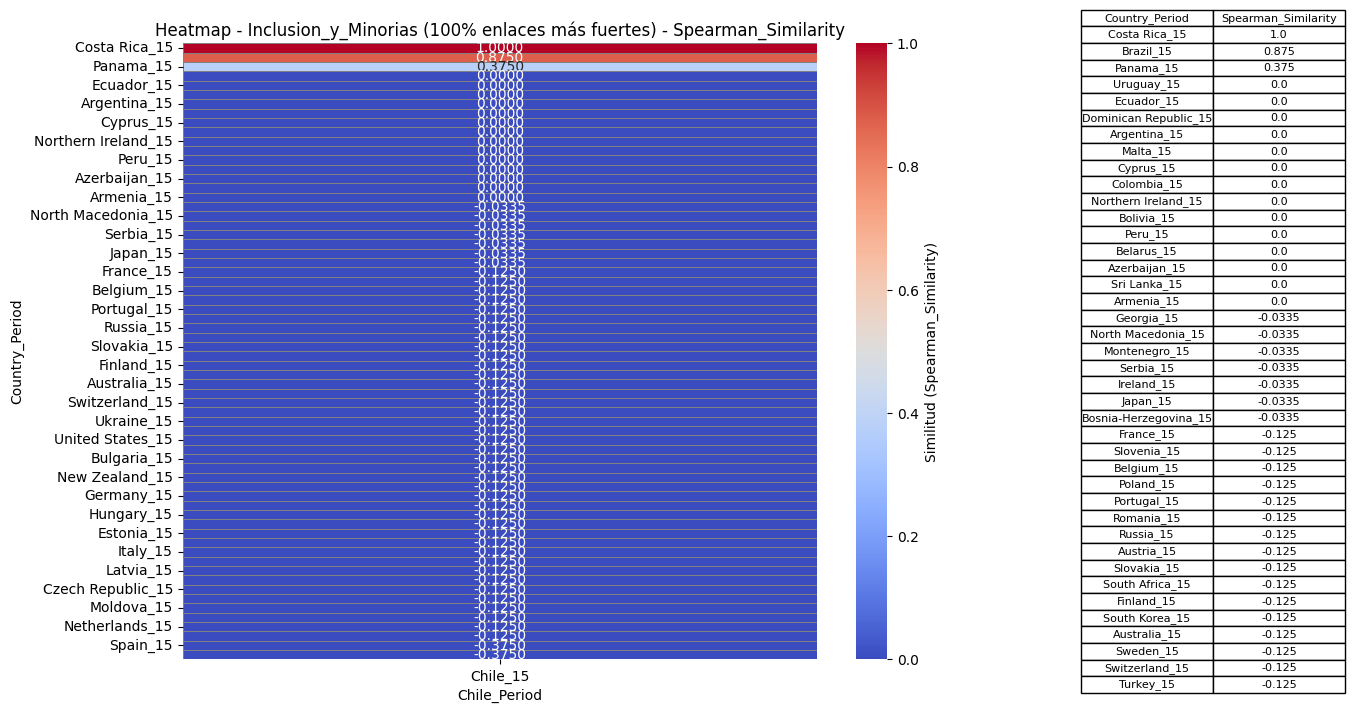

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:75: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


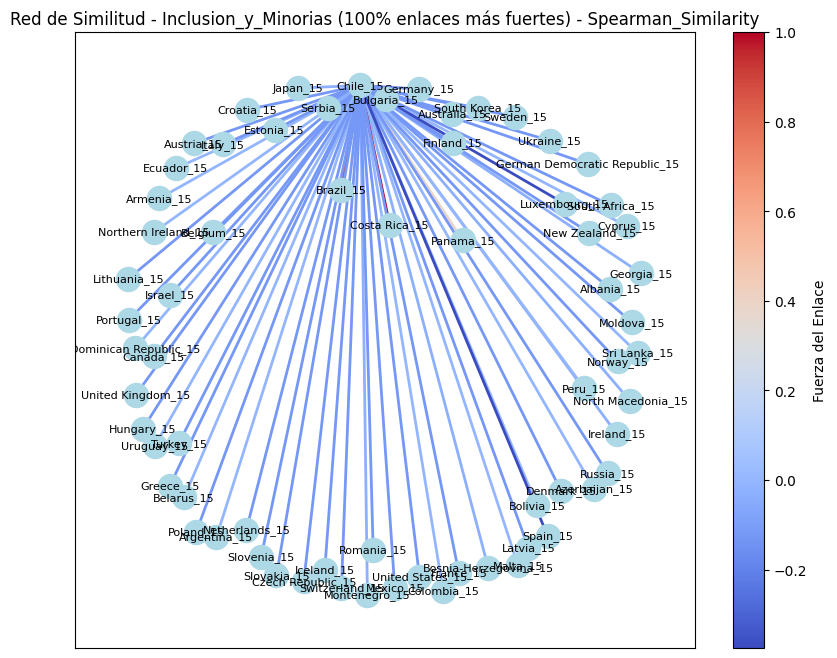

Se identificaron 15 clusters para el aspecto 'Inclusion_y_Minorias'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:94: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


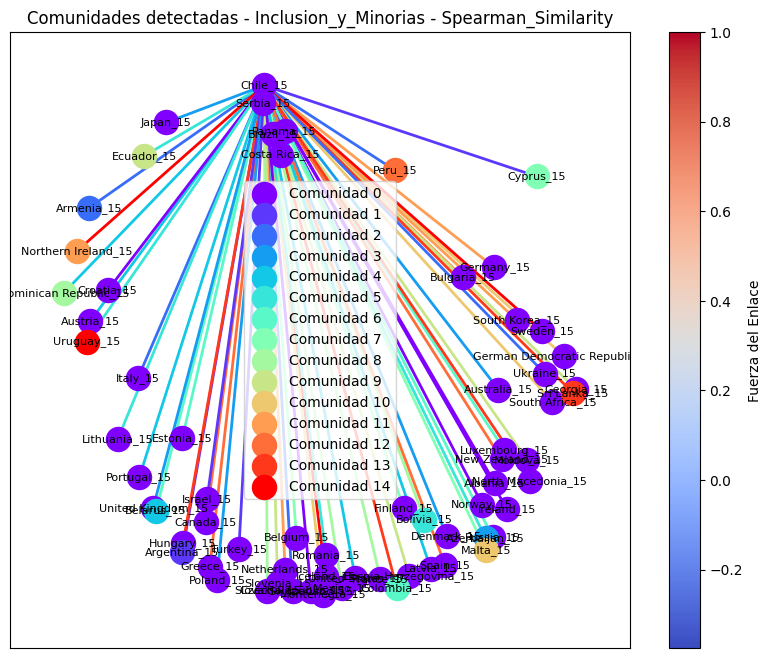

           Nodo  Degree_Centrality  Betweenness_Centrality  \
0      Chile_15           1.000000            11304.592774   
1    Albania_15           0.015152                0.000000   
2  Argentina_15           0.015152                0.000000   
3    Armenia_15           0.015152                0.000000   
4  Australia_15           0.015152                0.000000   

   Eigenvector_Centrality               Aspecto  
0                0.707110  Inclusion_y_Minorias  
1                0.087038  Inclusion_y_Minorias  
2                0.087038  Inclusion_y_Minorias  
3                0.087038  Inclusion_y_Minorias  
4                0.087038  Inclusion_y_Minorias  
Generando análisis para distancia Euclideana en Inclusion_y_Minorias


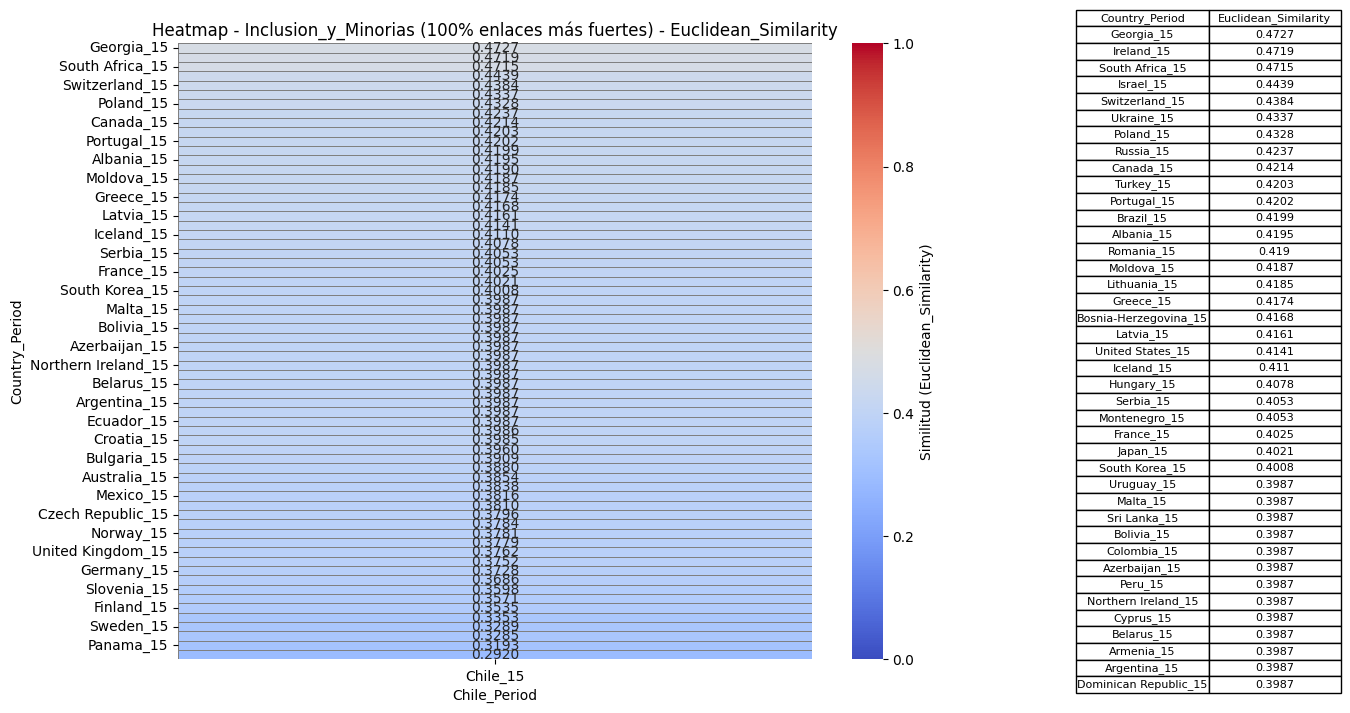

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:75: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


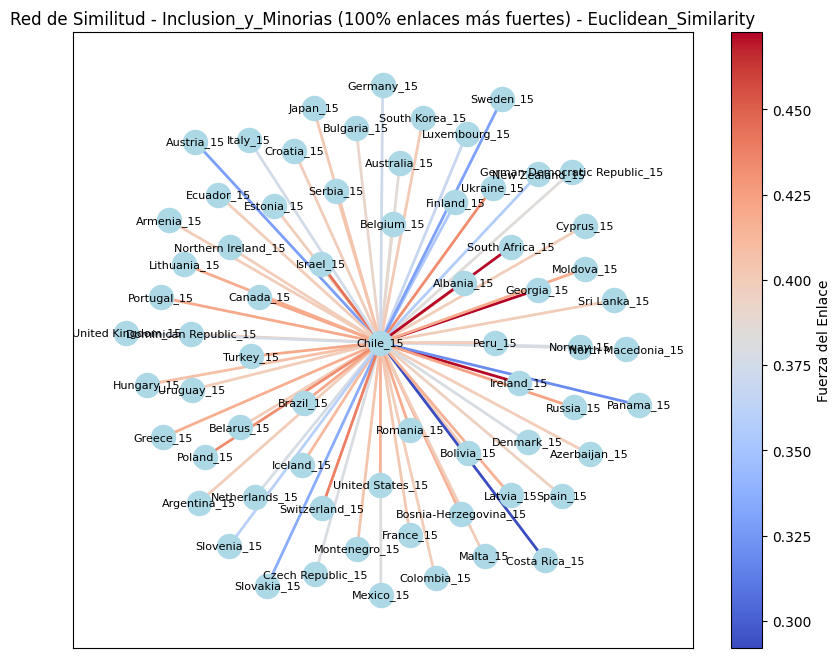

Se identificaron 1 clusters para el aspecto 'Inclusion_y_Minorias'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:94: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


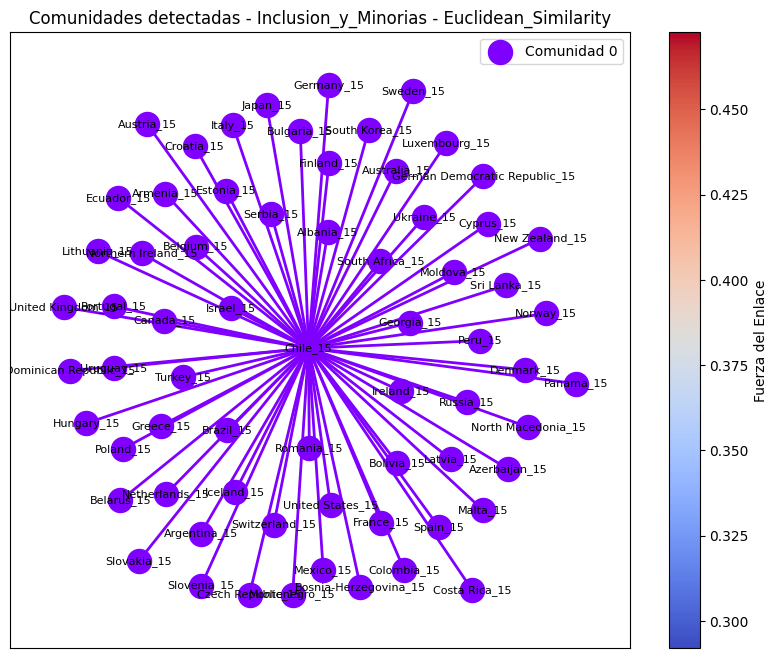

           Nodo  Degree_Centrality  Betweenness_Centrality  \
0      Chile_15           1.000000                     1.0   
1    Albania_15           0.015152                     0.0   
2  Argentina_15           0.015152                     0.0   
3    Armenia_15           0.015152                     0.0   
4  Australia_15           0.015152                     0.0   

   Eigenvector_Centrality               Aspecto  
0                0.707110  Inclusion_y_Minorias  
1                0.087038  Inclusion_y_Minorias  
2                0.087038  Inclusion_y_Minorias  
3                0.087038  Inclusion_y_Minorias  
4                0.087038  Inclusion_y_Minorias  

Analizando: Orden_y_Corrupcion en el período 15
country_period: Albania_15
Country_data: per503      3.802823
per705      0.165306
per201_2    0.000000
Name: 0, dtype: float64
Chile_data: per503      7.311582
per705      0.274453
per201_2    1.145095
Name: 102, dtype: float64
Dist Euclideana 3.6924989137672073
similaridad = 

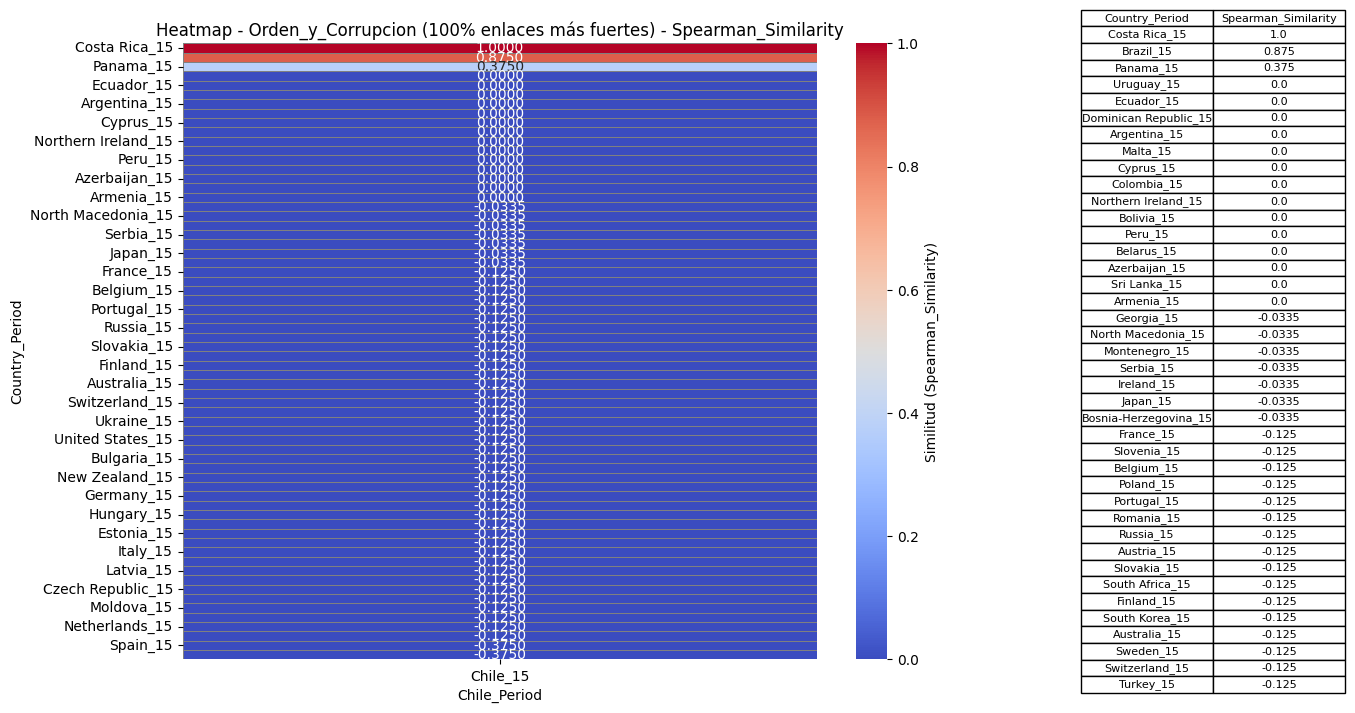

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:75: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


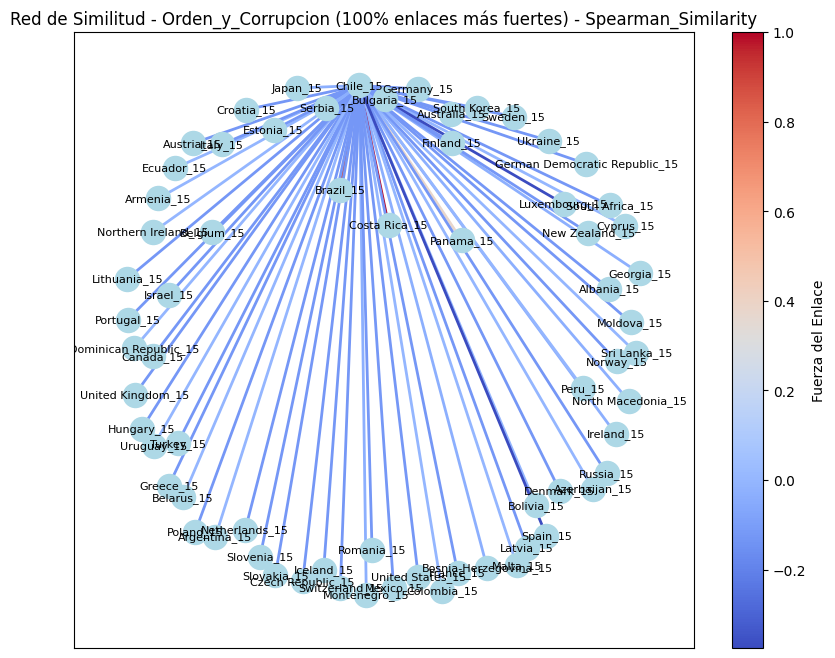

Se identificaron 15 clusters para el aspecto 'Orden_y_Corrupcion'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:94: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


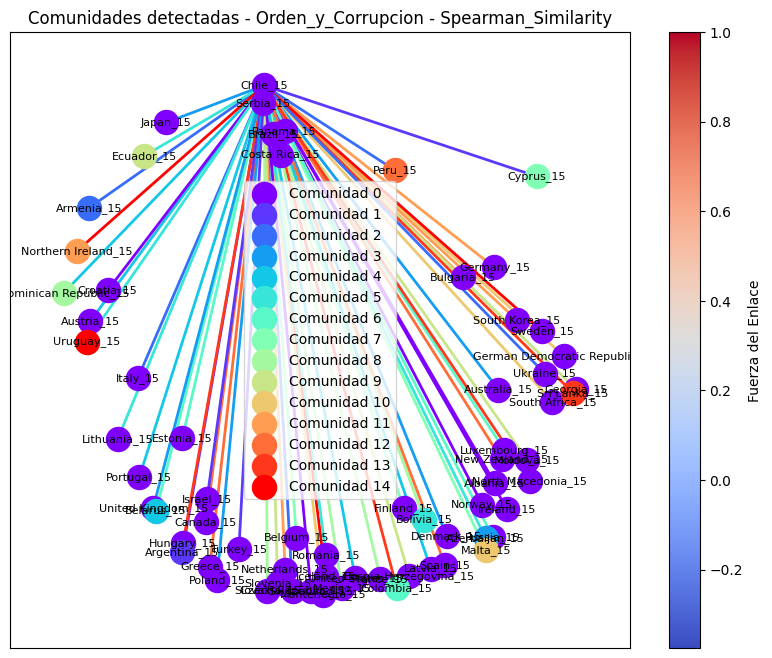

           Nodo  Degree_Centrality  Betweenness_Centrality  \
0      Chile_15           1.000000            11304.592774   
1    Albania_15           0.015152                0.000000   
2  Argentina_15           0.015152                0.000000   
3    Armenia_15           0.015152                0.000000   
4  Australia_15           0.015152                0.000000   

   Eigenvector_Centrality             Aspecto  
0                0.707110  Orden_y_Corrupcion  
1                0.087038  Orden_y_Corrupcion  
2                0.087038  Orden_y_Corrupcion  
3                0.087038  Orden_y_Corrupcion  
4                0.087038  Orden_y_Corrupcion  
Generando análisis para distancia Euclideana en Orden_y_Corrupcion


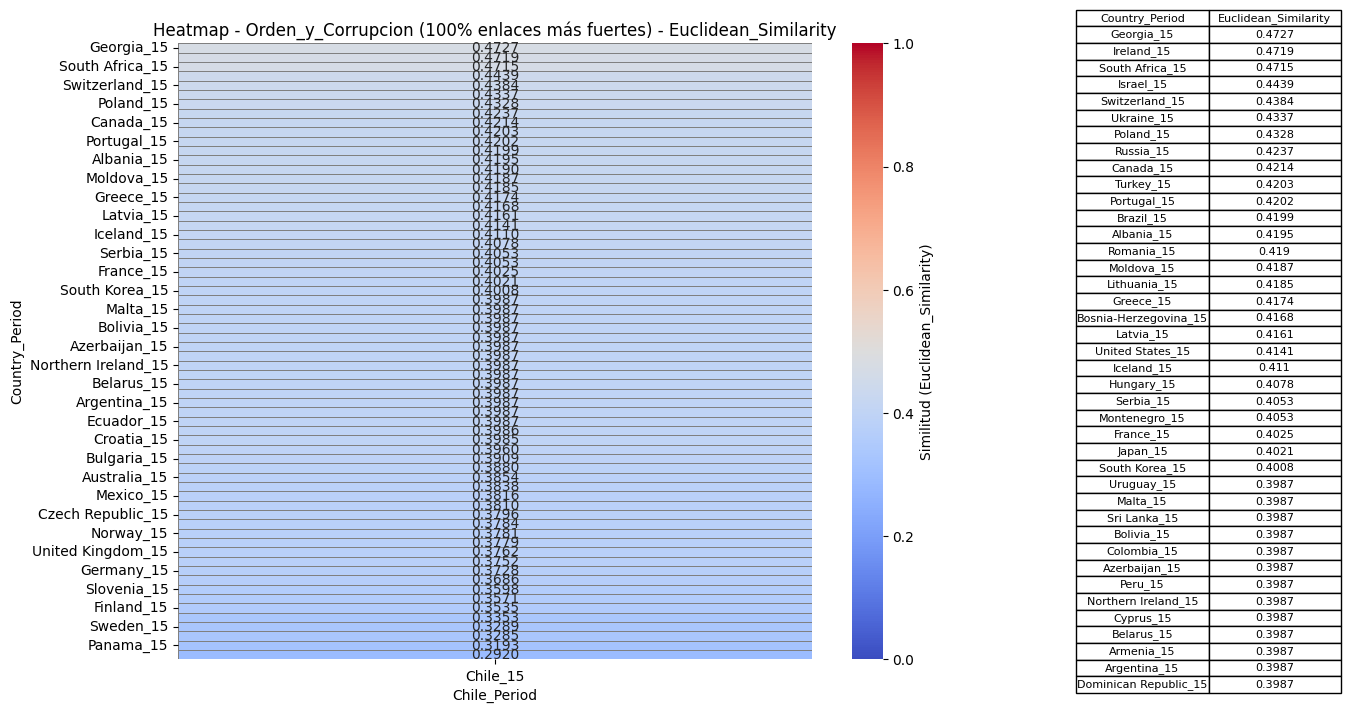

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:75: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


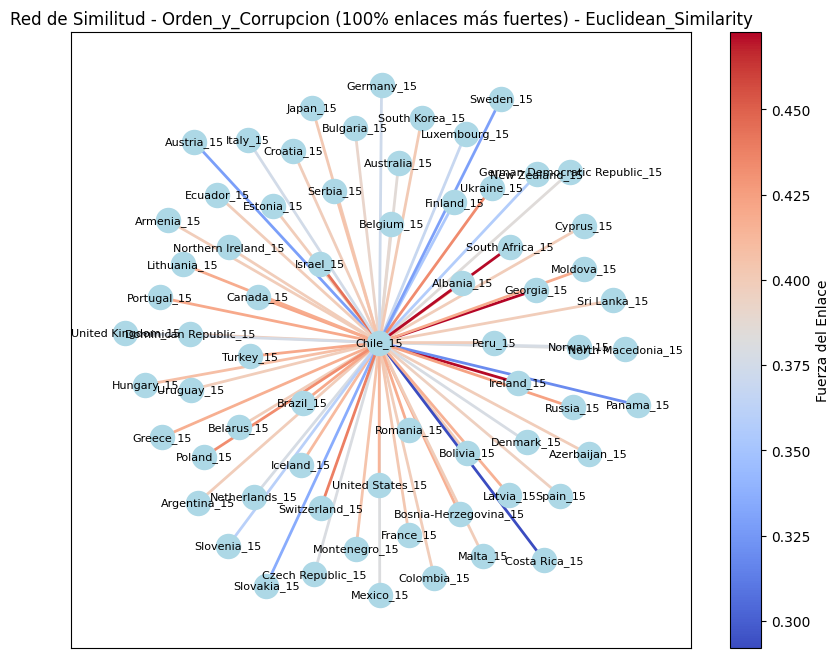

Se identificaron 1 clusters para el aspecto 'Orden_y_Corrupcion'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:94: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


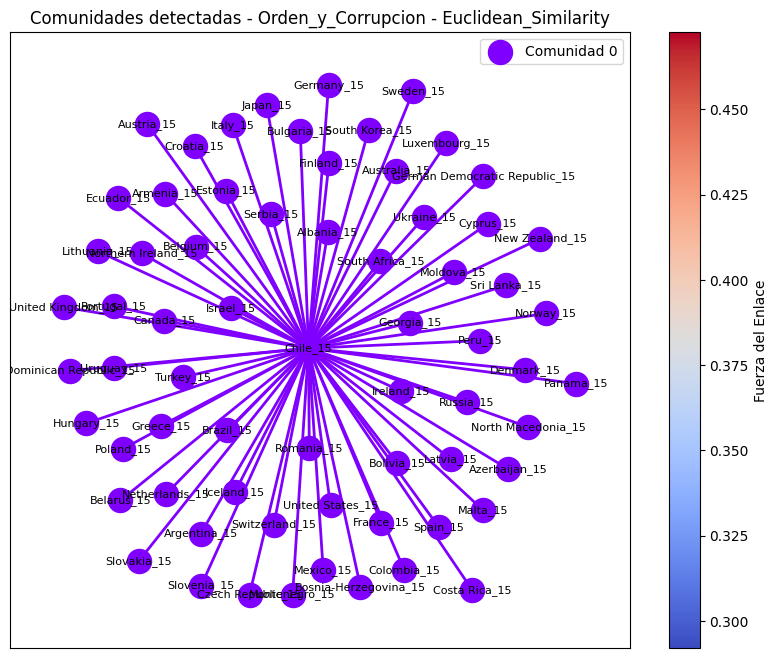

           Nodo  Degree_Centrality  Betweenness_Centrality  \
0      Chile_15           1.000000                     1.0   
1    Albania_15           0.015152                     0.0   
2  Argentina_15           0.015152                     0.0   
3    Armenia_15           0.015152                     0.0   
4  Australia_15           0.015152                     0.0   

   Eigenvector_Centrality             Aspecto  
0                0.707110  Orden_y_Corrupcion  
1                0.087038  Orden_y_Corrupcion  
2                0.087038  Orden_y_Corrupcion  
3                0.087038  Orden_y_Corrupcion  
4                0.087038  Orden_y_Corrupcion  

Analizando: Medio_Ambiente_y_Sostenibilidad en el período 15
country_period: Albania_15
Country_data: per503      3.802823
per705      0.165306
per201_2    0.000000
Name: 0, dtype: float64
Chile_data: per503      7.311582
per705      0.274453
per201_2    1.145095
Name: 102, dtype: float64
Dist Euclideana 3.6924989137672073
similaridad =

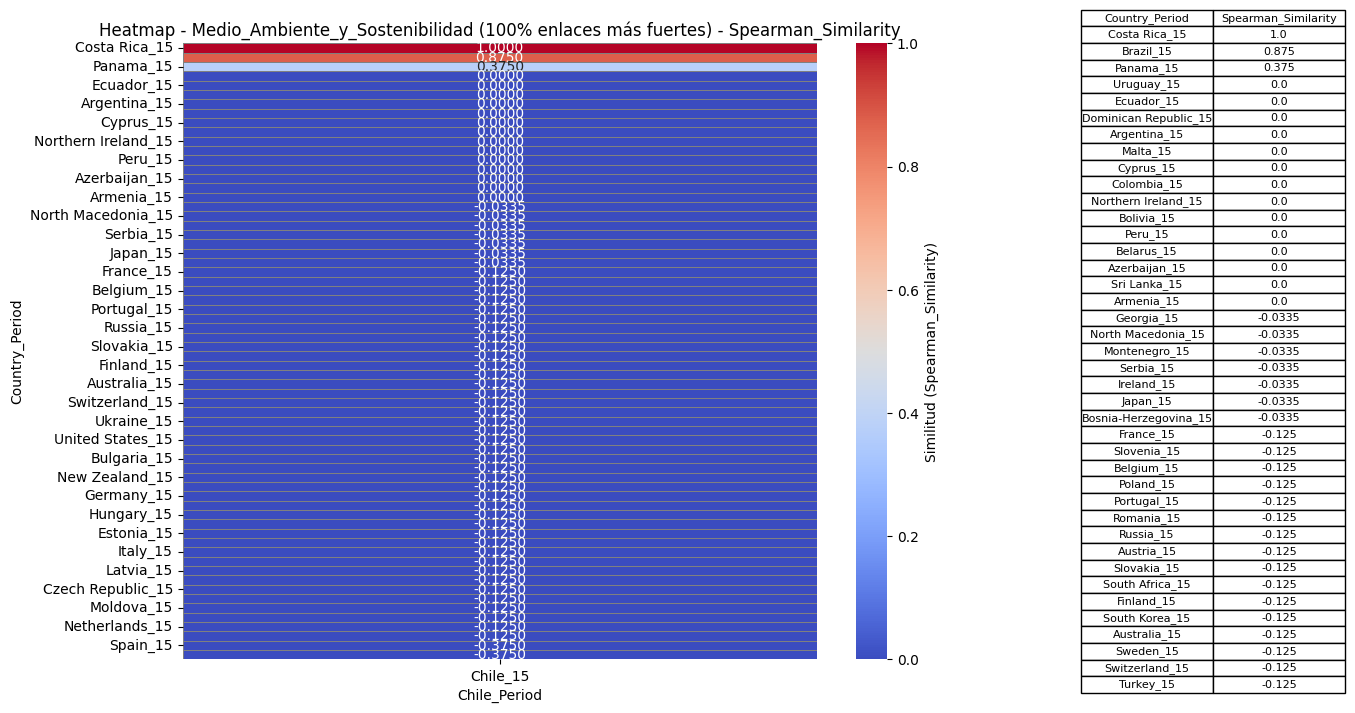

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:75: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


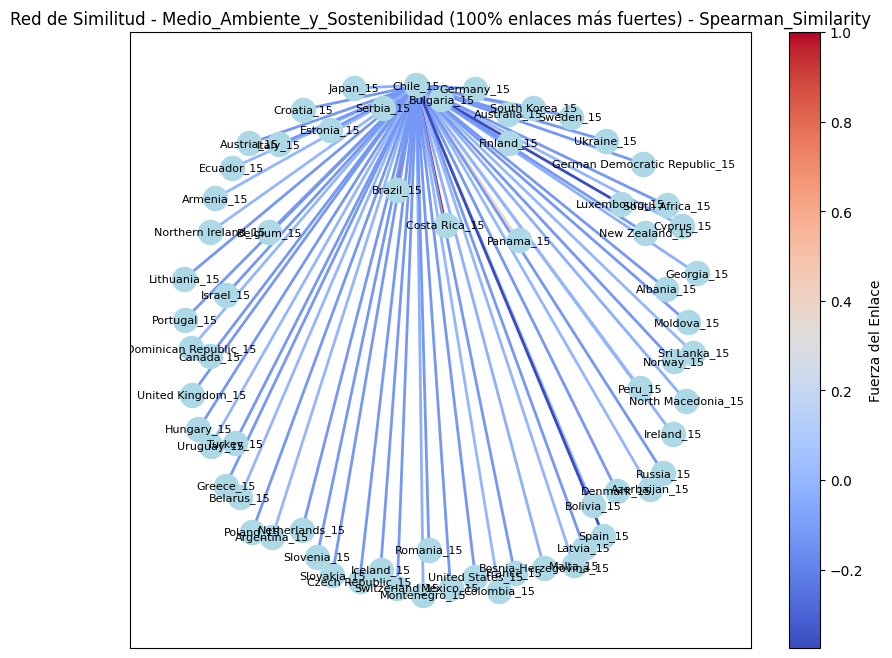

Se identificaron 15 clusters para el aspecto 'Medio_Ambiente_y_Sostenibilidad'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:94: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


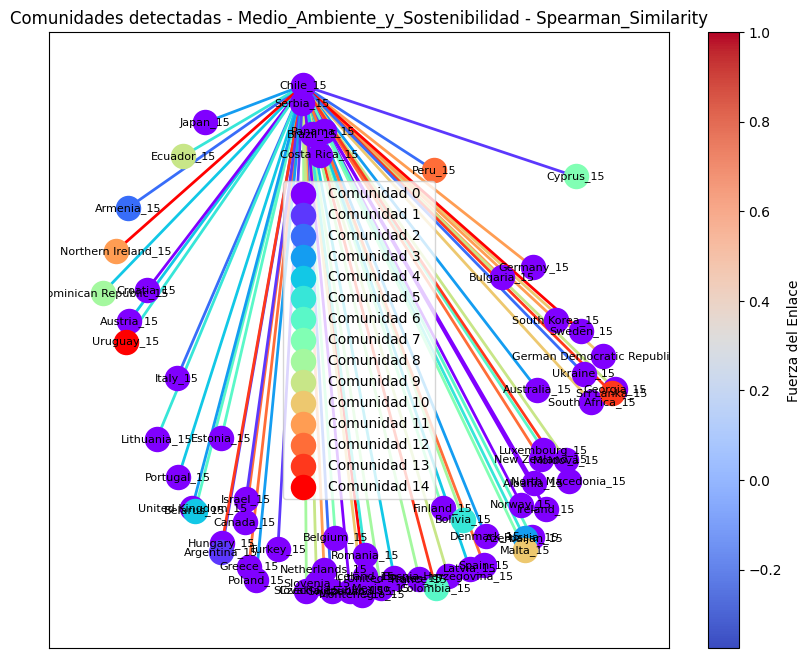

           Nodo  Degree_Centrality  Betweenness_Centrality  \
0      Chile_15           1.000000            11304.592774   
1    Albania_15           0.015152                0.000000   
2  Argentina_15           0.015152                0.000000   
3    Armenia_15           0.015152                0.000000   
4  Australia_15           0.015152                0.000000   

   Eigenvector_Centrality                          Aspecto  
0                0.707110  Medio_Ambiente_y_Sostenibilidad  
1                0.087038  Medio_Ambiente_y_Sostenibilidad  
2                0.087038  Medio_Ambiente_y_Sostenibilidad  
3                0.087038  Medio_Ambiente_y_Sostenibilidad  
4                0.087038  Medio_Ambiente_y_Sostenibilidad  
Generando análisis para distancia Euclideana en Medio_Ambiente_y_Sostenibilidad


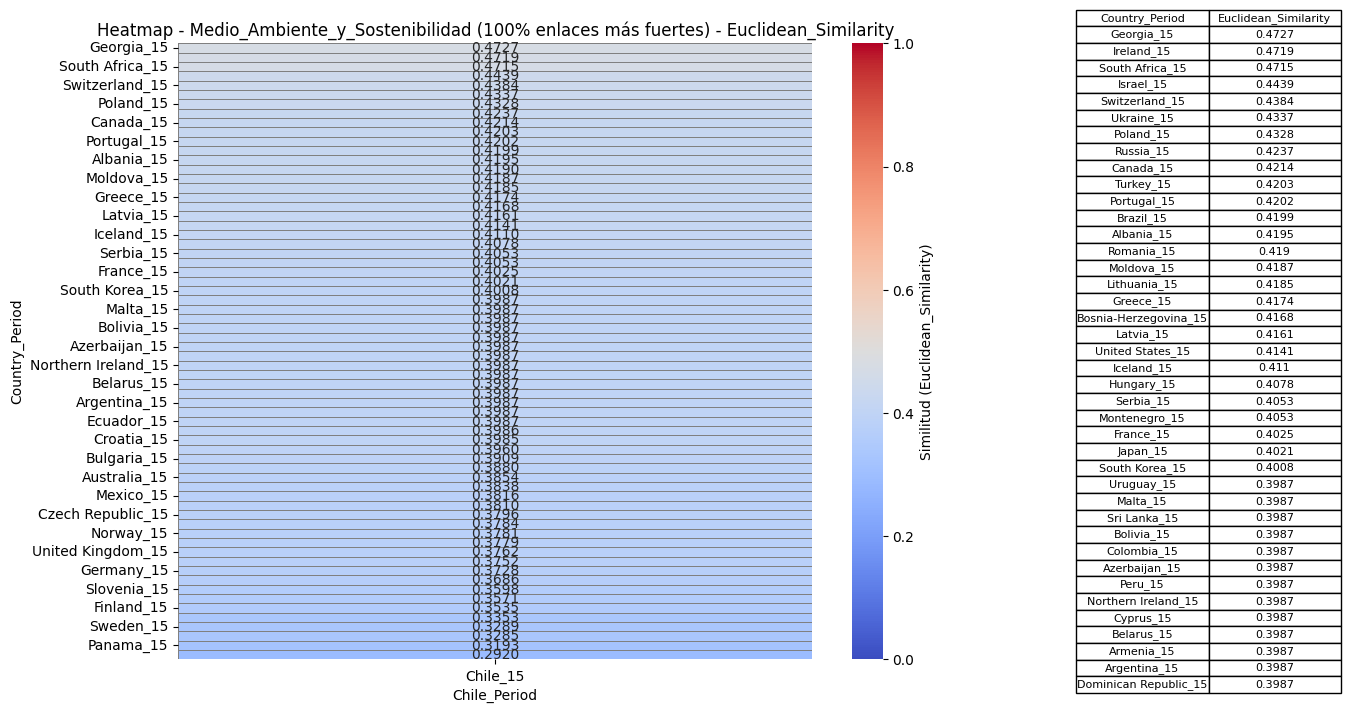

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:75: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


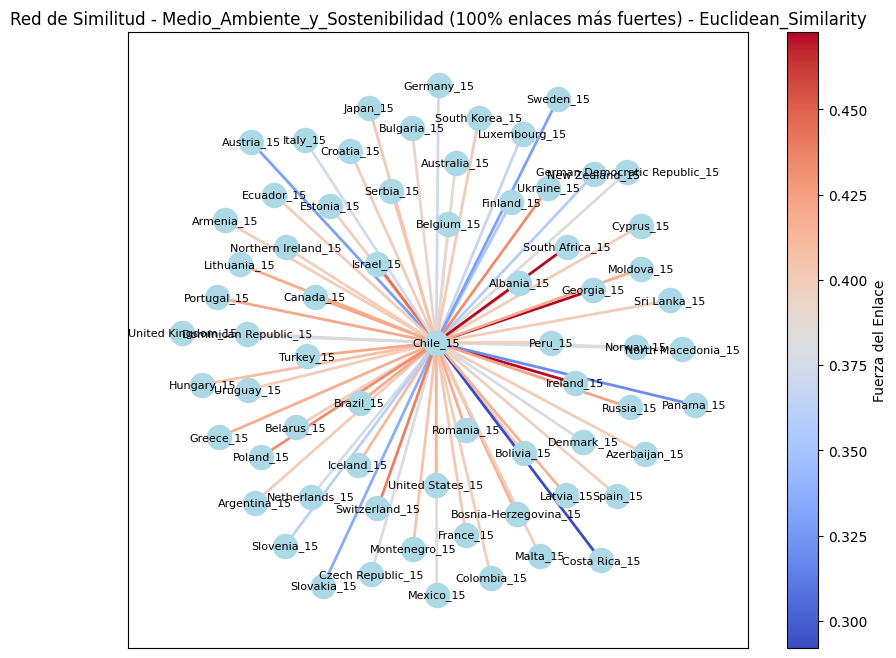

Se identificaron 1 clusters para el aspecto 'Medio_Ambiente_y_Sostenibilidad'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:94: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


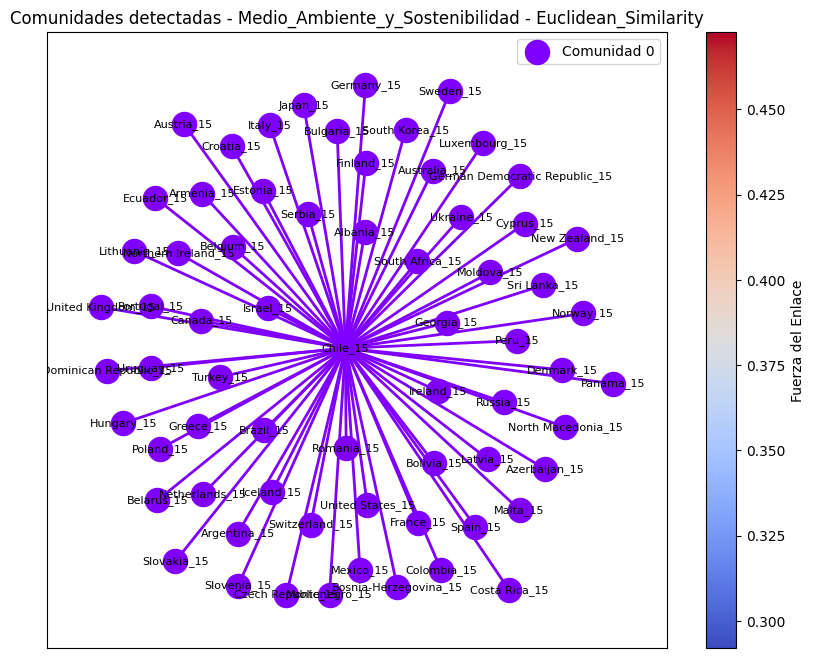

           Nodo  Degree_Centrality  Betweenness_Centrality  \
0      Chile_15           1.000000                     1.0   
1    Albania_15           0.015152                     0.0   
2  Argentina_15           0.015152                     0.0   
3    Armenia_15           0.015152                     0.0   
4  Australia_15           0.015152                     0.0   

   Eigenvector_Centrality                          Aspecto  
0                0.707110  Medio_Ambiente_y_Sostenibilidad  
1                0.087038  Medio_Ambiente_y_Sostenibilidad  
2                0.087038  Medio_Ambiente_y_Sostenibilidad  
3                0.087038  Medio_Ambiente_y_Sostenibilidad  
4                0.087038  Medio_Ambiente_y_Sostenibilidad  

Analizando: Pueblos_Originarios en el período 15
country_period: Albania_15
Country_data: per503      3.802823
per705      0.165306
per201_2    0.000000
Name: 0, dtype: float64
Chile_data: per503      7.311582
per705      0.274453
per201_2    1.145095
Name: 10

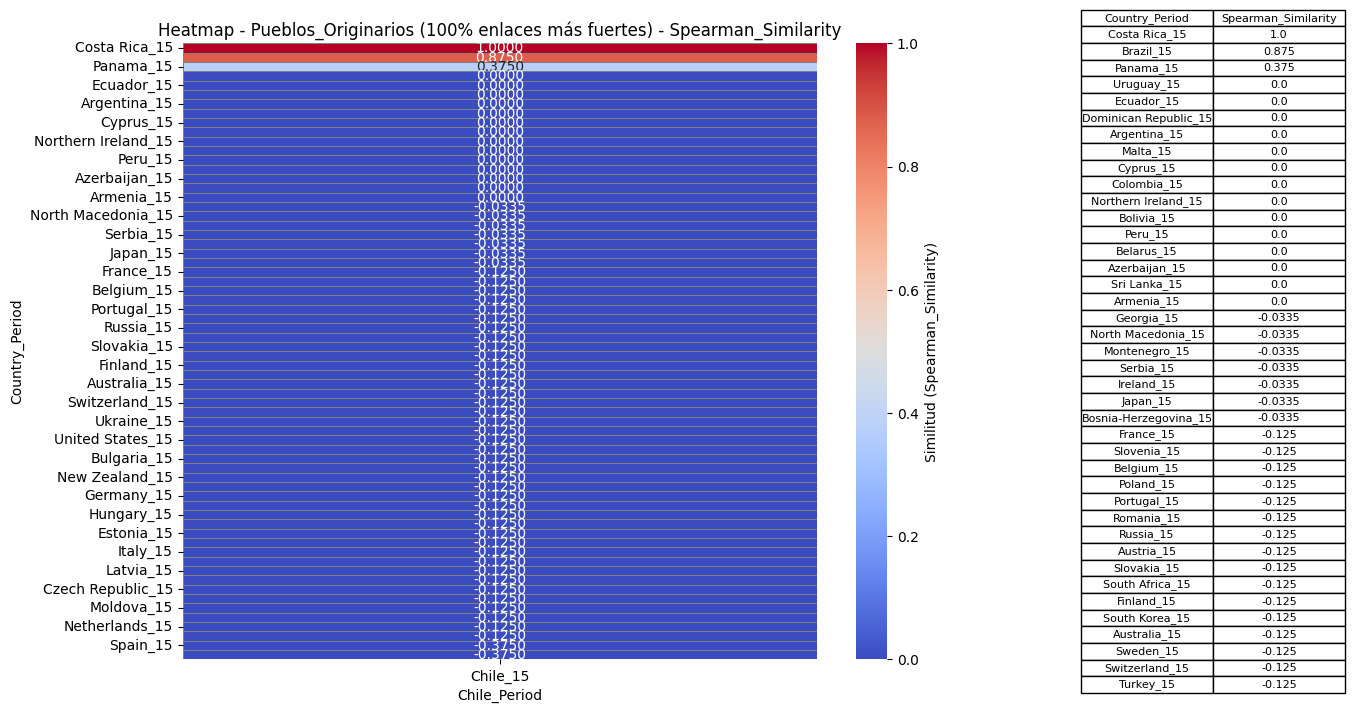

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:75: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


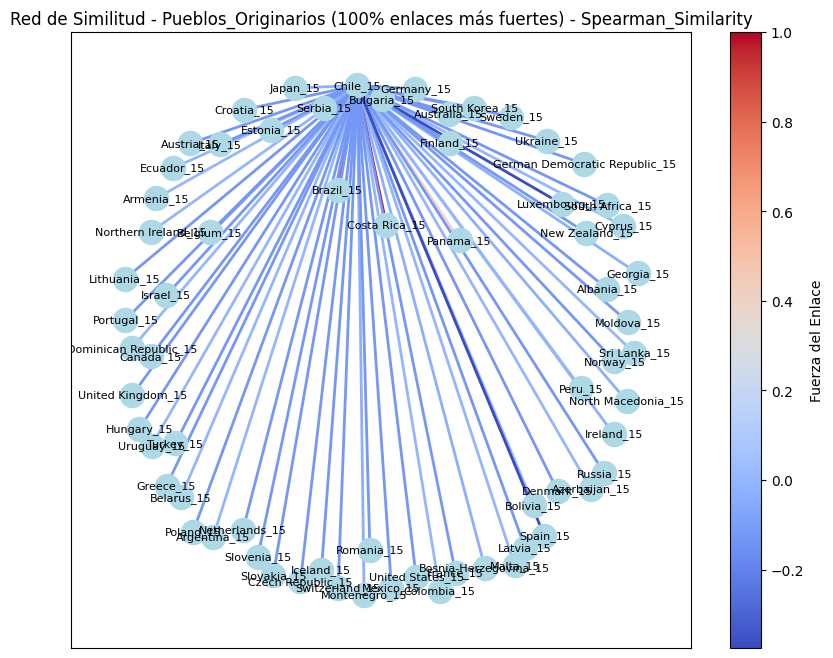

Se identificaron 15 clusters para el aspecto 'Pueblos_Originarios'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:94: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


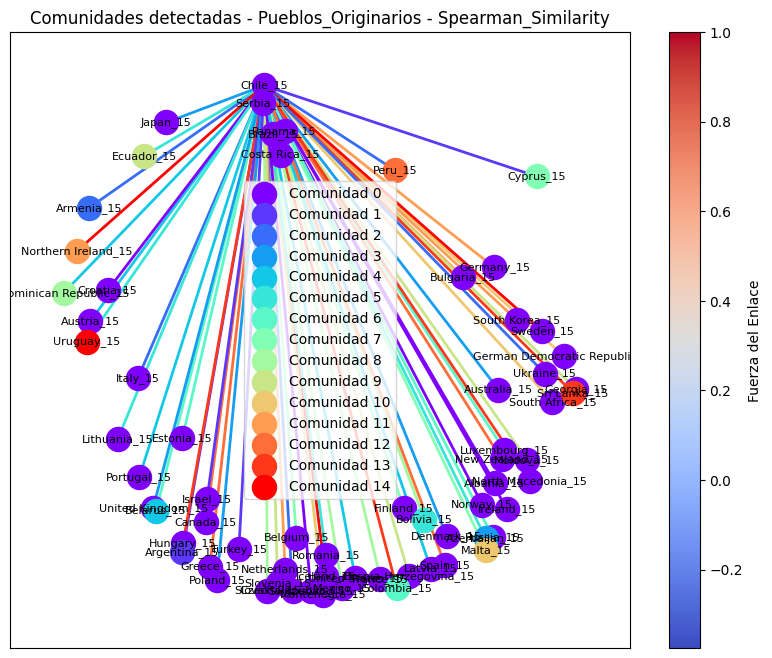

           Nodo  Degree_Centrality  Betweenness_Centrality  \
0      Chile_15           1.000000            11304.592774   
1    Albania_15           0.015152                0.000000   
2  Argentina_15           0.015152                0.000000   
3    Armenia_15           0.015152                0.000000   
4  Australia_15           0.015152                0.000000   

   Eigenvector_Centrality              Aspecto  
0                0.707110  Pueblos_Originarios  
1                0.087038  Pueblos_Originarios  
2                0.087038  Pueblos_Originarios  
3                0.087038  Pueblos_Originarios  
4                0.087038  Pueblos_Originarios  
Generando análisis para distancia Euclideana en Pueblos_Originarios


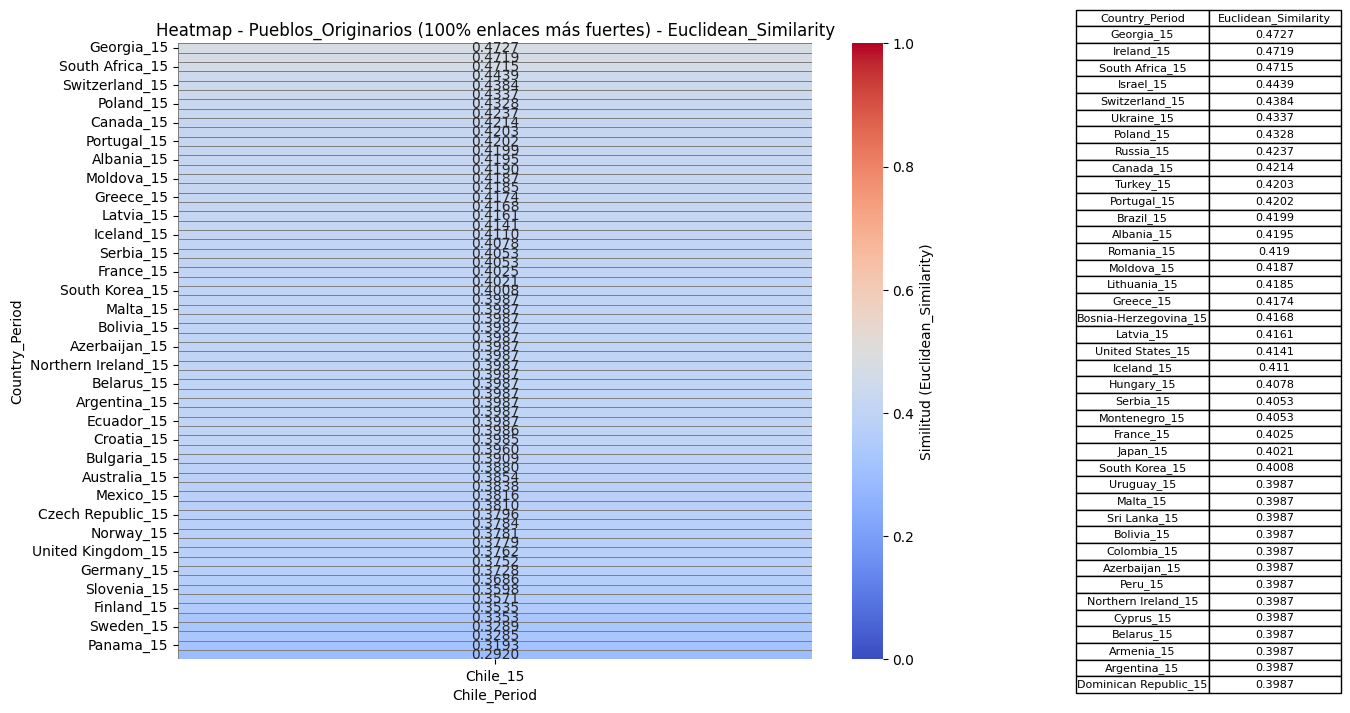

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:75: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


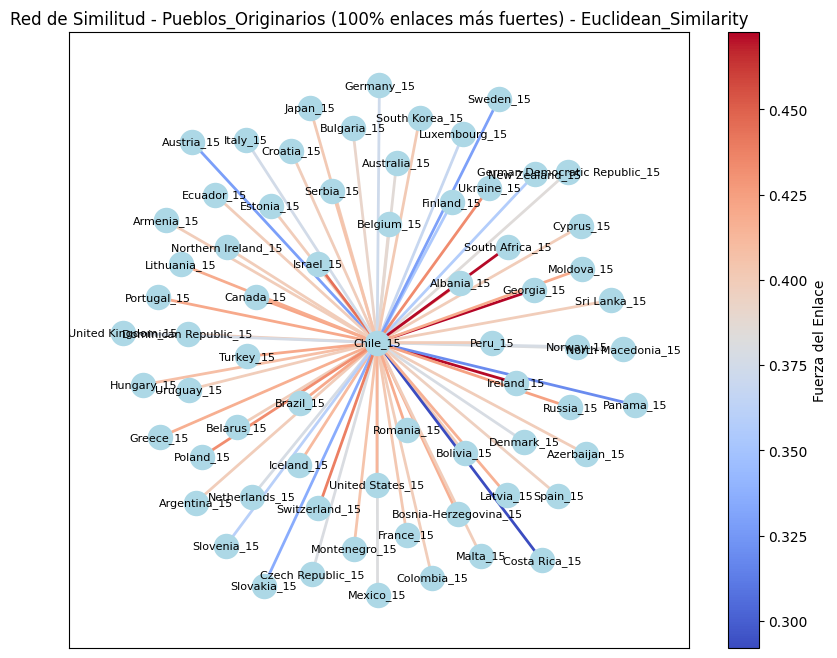

Se identificaron 1 clusters para el aspecto 'Pueblos_Originarios'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8593/2183296237.py:94: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


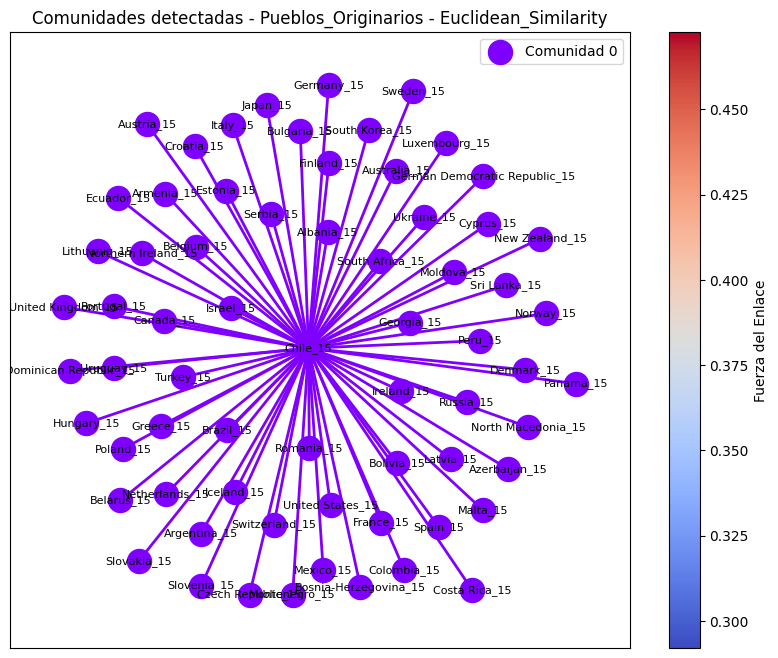

           Nodo  Degree_Centrality  Betweenness_Centrality  \
0      Chile_15           1.000000                     1.0   
1    Albania_15           0.015152                     0.0   
2  Argentina_15           0.015152                     0.0   
3    Armenia_15           0.015152                     0.0   
4  Australia_15           0.015152                     0.0   

   Eigenvector_Centrality              Aspecto  
0                0.707110  Pueblos_Originarios  
1                0.087038  Pueblos_Originarios  
2                0.087038  Pueblos_Originarios  
3                0.087038  Pueblos_Originarios  
4                0.087038  Pueblos_Originarios  


In [22]:
# Ejecutar el análisis para cada aspecto en un período específico
def ejecutar_analisis_por_aspecto(df, df_aspectos, porcentaje, periodo):
    for aspecto in df_aspectos['aspecto']:
        print(f'\nAnalizando: {aspecto} en el período {periodo}')
        
        # Calcular similitudes para el período seleccionado
        # df_similarity_spearman, df_similarity_euclidean = calcular_similitud(df, df_aspectos, porcentaje, periodo)
        df_similarity_spearman, df_similarity_euclidean = calcular_similitud(df_5_extended, df_aspectos, 100, 15)

        
        # Generar red y calcular métricas de centralidad para Spearman
        print(f'Generando análisis para correlación de Spearman en {aspecto}')
        df_centralities_spearman = generar_red_y_calcular_metricas(df_similarity_spearman, aspecto, 'Spearman_Similarity', porcentaje)
        print(df_centralities_spearman.head())
        
        # Generar red y calcular métricas de centralidad para Euclidean
        print(f'Generando análisis para distancia Euclideana en {aspecto}')
        df_centralities_euclidean = generar_red_y_calcular_metricas(df_similarity_euclidean, aspecto, 'Euclidean_Similarity', porcentaje)
        print(df_centralities_euclidean.head())

# Llamar a la función con el período y el porcentaje de enlaces más fuertes deseado
ejecutar_analisis_por_aspecto(df_5_extended, df_aspectos, 100, 15)  # Período 15 como ejemplo
